In [89]:
# 需要哪些品种来展示
dict1 = {'白糖':'SR','豆粕':'M','玉米':'C','玉米淀粉':'CS','苹果':'AP','菜粕':'RM','纯碱':'SA','玻璃':'FG','甲醇':'MA'}

# 从数据库中取数据
import pymysql.cursors 
 
 
dbname = 'db_eastmoney'
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='0000',
                             db=dbname,
                             charset='utf8',
                             cursorclass=pymysql.cursors.DictCursor)
results =[]
try:
    with connection.cursor() as cursor:
        sql = '''SHOW TABLES'''
        cursor.execute(sql)
        result = cursor.fetchall() 
        for i in range(len(result)):
            results.append(result[i]['Tables_in_'+dbname])
finally:
    connection.close()
    
s = {value.lower() for key,value in dict1.items()}
# 将大写变小写，取出表名
tablename = []
for i in results:
    index = i.index('_')
    for a in s:
        if i[index+1:]==a:
            tablename.append(i)

import pandas as pd
import re
# 从数据库中取出数据
abitrage_dic = {}
conn = pymysql.connect(host = "localhost",port=3306,user='root',passwd='0000',db='db_eastmoney',charset="utf8")
for i in tablename:
    sql_query = 'SELECT * FROM '+i
    # 从mysql中读取表
    df1 = pd.read_sql(sql_query, con=conn)
    # 中文转码
    df1.name = df1.name.apply(lambda x:eval(repr(x).replace('\\\\', '\\')))
    # TA特殊处理
    if 'TA' in df1.loc[0,'name']:
        # 提取字母
        name = ''.join(re.findall(r'[A-Za-z]', df1.loc[0,'name']))  
    else:
        # 提取中文
        name = ''.join(re.findall(u"[\u4e00-\u9fa5]+", df1.loc[0,'name']))
        
    # 提取字母  code  AP 
    code = ''.join(re.findall(r'[A-Za-z]', df1.loc[0,'code']))
    # 去掉主力和次主力的行 带有- 的行
    df1 = df1[(df1.name.str.contains('主力')==False) & (df1.new_p!='-')]
    # 转换类型
    df1['new_p'] = df1['new_p'].astype('float64')
    df1['volume'] = df1['volume'].astype('int64')
    df1['money'] = df1['new_p']*df1['volume']
    
    if len(df1)>=2:
        date = df1.date.tolist()[0]
        abitrage_dic[name] = {'date':date,'合约':df1.code.tolist(),'主力':df1.loc[df1.dominant==1,'code'].values[0],'次主力':df1.loc[df1.dominant==2,'code'].values[0]}
conn.close()  #使用完后记得关掉
for key,value in abitrage_dic.items():
    print(key,value)

苹果 {'date': '2021-07-15', '合约': ['AP110', 'AP111', 'AP112', 'AP201', 'AP203', 'AP204', 'AP205'], '主力': 'AP110', '次主力': 'AP201'}
玻璃 {'date': '2021-07-15', '合约': ['FG108', 'FG109', 'FG110', 'FG111', 'FG112', 'FG201', 'FG202', 'FG203', 'FG204', 'FG205', 'FG206', 'FG207'], '主力': 'FG109', '次主力': 'FG201'}
甲醇 {'date': '2021-07-15', '合约': ['MA108', 'MA109', 'MA110', 'MA111', 'MA112', 'MA201', 'MA202', 'MA203', 'MA204', 'MA205', 'MA206'], '主力': 'MA109', '次主力': 'MA110'}
菜粕 {'date': '2021-07-15', '合约': ['RM108', 'RM109', 'RM111', 'RM201', 'RM203', 'RM205'], '主力': 'RM109', '次主力': 'RM201'}
纯碱 {'date': '2021-07-15', '合约': ['SA108', 'SA109', 'SA110', 'SA111', 'SA112', 'SA201', 'SA202', 'SA203', 'SA204', 'SA205', 'SA206', 'SA207'], '主力': 'SA109', '次主力': 'SA201'}
白糖 {'date': '2021-07-15', '合约': ['SR109', 'SR111', 'SR201', 'SR203', 'SR205', 'SR207'], '主力': 'SR109', '次主力': 'SR111'}
玉米 {'date': '2021-07-15', '合约': ['c2109', 'c2111', 'c2201', 'c2203', 'c2205', 'c2207'], '主力': 'c2109', '次主力': 'c2201'}
玉米淀粉 

In [90]:
# 获取现货价格，放入字典
import pandas as pd
df = pd.read_csv(r'现货价格.csv',encoding='gb2312')
goods_dict = df.iloc[-1].to_dict()
for key,value in abitrage_dic.items():
    value['现货'] = goods_dict[key]
for key,value in abitrage_dic.items():
    print(key,value)


苹果 {'date': '2021-07-15', '合约': ['AP110', 'AP111', 'AP112', 'AP201', 'AP203', 'AP204', 'AP205'], '主力': 'AP110', '次主力': 'AP201', '现货': 6000}
玻璃 {'date': '2021-07-15', '合约': ['FG108', 'FG109', 'FG110', 'FG111', 'FG112', 'FG201', 'FG202', 'FG203', 'FG204', 'FG205', 'FG206', 'FG207'], '主力': 'FG109', '次主力': 'FG201', '现货': 2848.0}
甲醇 {'date': '2021-07-15', '合约': ['MA108', 'MA109', 'MA110', 'MA111', 'MA112', 'MA201', 'MA202', 'MA203', 'MA204', 'MA205', 'MA206'], '主力': 'MA109', '次主力': 'MA110', '现货': 2640.0}
菜粕 {'date': '2021-07-15', '合约': ['RM108', 'RM109', 'RM111', 'RM201', 'RM203', 'RM205'], '主力': 'RM109', '次主力': 'RM201', '现货': 3130}
纯碱 {'date': '2021-07-15', '合约': ['SA108', 'SA109', 'SA110', 'SA111', 'SA112', 'SA201', 'SA202', 'SA203', 'SA204', 'SA205', 'SA206', 'SA207'], '主力': 'SA109', '次主力': 'SA201', '现货': 2250.0}
白糖 {'date': '2021-07-15', '合约': ['SR109', 'SR111', 'SR201', 'SR203', 'SR205', 'SR207'], '主力': 'SR109', '次主力': 'SR111', '现货': 5610}
玉米 {'date': '2021-07-15', '合约': ['c2109', 'c21

In [91]:
import akshare as ak
from datetime import datetime
import re
# 取出各个合约的价格
# 取出合约的现货价格
# 画图
for key,value in abitrage_dic.items():
    name = key
    time = value['date']
    code_l = value['合约']
    num = ''.join(re.findall(r'\d*', code_l[0]))
    if len(num)==3:
        code_l = [''.join(re.findall(r'[A-Za-z]', i))+'2'+ ''.join(re.findall(r'\d*', i)) for i in code_l]
    c_p = {}
    c_p['现货'] = value['现货']
    for i in code_l:
        data = ak.futures_zh_minute_sina(symbol=i, period="60")
        data['date'] = data['date'].apply(lambda x:datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
        data.close = data.close.astype('float64')
        data = data[data.date==datetime.strptime(time+' 15:00:00', "%Y-%m-%d %H:%M:%S")]
        if data.empty==True:
            continue
        close = data.iloc[-1].close
        c_p[i] = close
    value.pop('合约')
    value['合约价格'] = c_p
    print(name,c_p)


苹果 {'现货': 6000, 'AP2110': 5983.0, 'AP2111': 5833.0, 'AP2112': 5888.0, 'AP2201': 6000.0, 'AP2203': 5961.0, 'AP2204': 6094.0, 'AP2205': 6240.0}
玻璃 {'现货': 2848.0, 'FG2108': 3005.0, 'FG2109': 3013.0, 'FG2110': 2997.0, 'FG2111': 2970.0, 'FG2112': 2970.0, 'FG2201': 2935.0, 'FG2202': 2891.0, 'FG2203': 2826.0, 'FG2204': 2831.0, 'FG2205': 2798.0, 'FG2206': 2762.0, 'FG2207': 2769.0}
甲醇 {'现货': 2640.0, 'MA2108': 2595.0, 'MA2109': 2636.0, 'MA2110': 2658.0, 'MA2111': 2668.0, 'MA2112': 2693.0, 'MA2201': 2703.0, 'MA2202': 2713.0, 'MA2203': 2690.0, 'MA2204': 2687.0, 'MA2205': 2672.0, 'MA2206': 2663.0}
菜粕 {'现货': 3130, 'RM2108': 3069.0, 'RM2109': 3069.0, 'RM2111': 2921.0, 'RM2201': 2906.0, 'RM2203': 2870.0, 'RM2205': 2891.0}
纯碱 {'现货': 2250.0, 'SA2108': 2259.0, 'SA2109': 2272.0, 'SA2110': 2361.0, 'SA2111': 2364.0, 'SA2112': 2480.0, 'SA2201': 2480.0, 'SA2203': 2526.0, 'SA2204': 2615.0, 'SA2205': 2615.0, 'SA2206': 2643.0, 'SA2207': 2650.0}
白糖 {'现货': 5610, 'SR2109': 5520.0, 'SR2111': 5562.0, 'SR2201': 5720.0

In [125]:
abitrage_dic
key_list = abitrage_dic.keys()
num_list = list(abitrage_dic.values())
num_list = [len(i['合约价格']) for i in num_list]
t = max(num_list)
sort_ab = dict(zip(key_list,num_list))
sort_ab = dict(sorted(sort_ab.items(),key=lambda x:x[1]))
sort_ab,t

({'白糖': 6,
  '玉米淀粉': 6,
  '菜粕': 7,
  '玉米': 7,
  '苹果': 8,
  '豆粕': 9,
  '甲醇': 12,
  '纯碱': 12,
  '玻璃': 13},
 13)

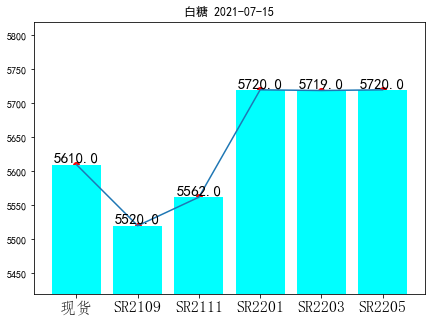

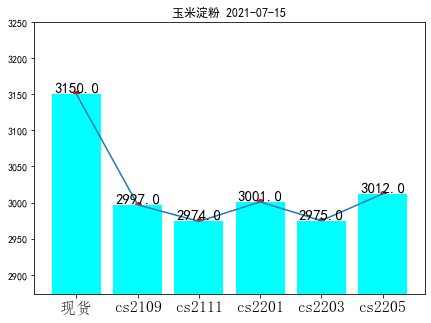

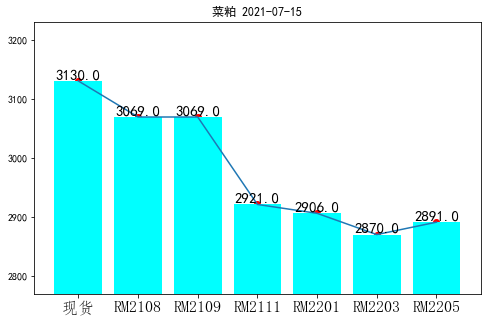

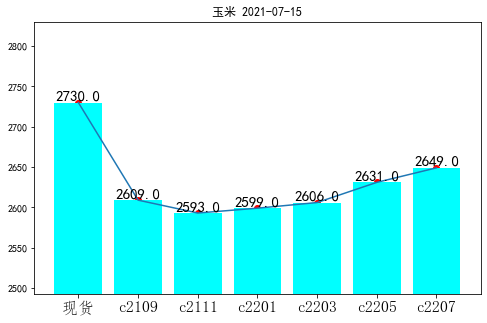

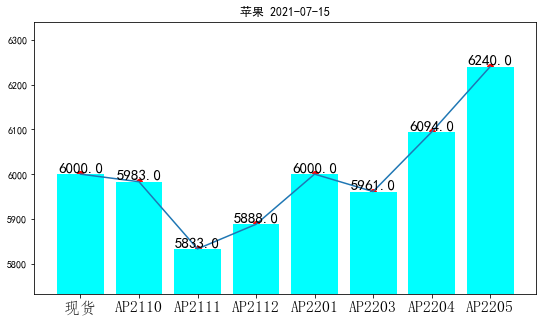

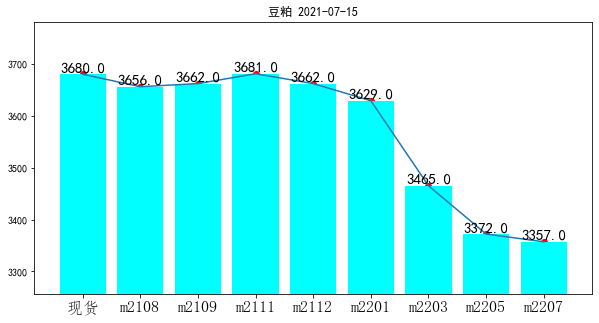

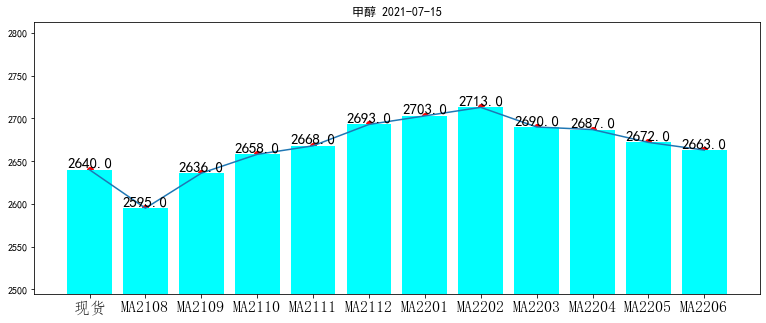

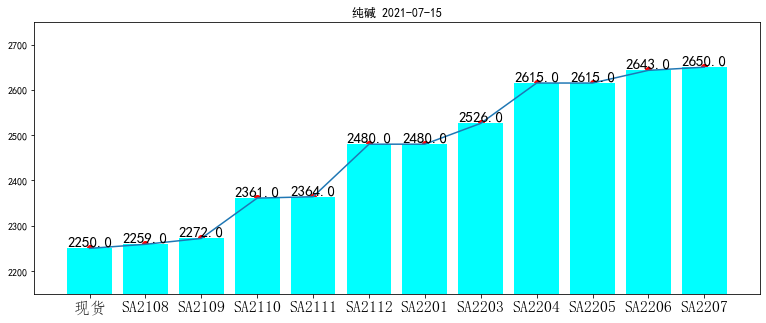

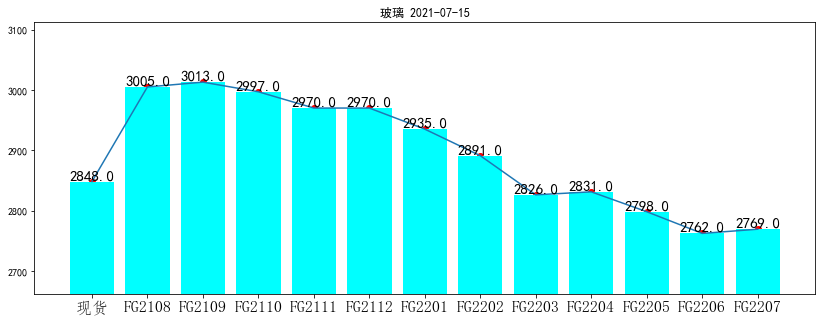

In [132]:
#plt画图
import matplotlib.pyplot as plt
import os
plt.rcParams['font.sans-serif']=['Simhei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
e = 0
path = r'C:\Users\17218\Desktop\image'
for key,value in sort_ab.items():
    date = abitrage_dic[key]['date']
    ft_name = key
    names = list(abitrage_dic[key]['合约价格'].keys())
    values = list(abitrage_dic[key]['合约价格'].values())
    n = value
    fig=plt.figure(figsize=(n+1,5))
    plt.ylim((min(values)-100,max(values)+100))
    plt.bar(names, values,color='cyan')
    plt.scatter(names, values,color='red')
    plt.plot(names, values)
    for a,b in abitrage_dic[key]['合约价格'].items():
      plt.text(a, b+0.5, '%.1f' % b, ha='center',weight = "light",va= 'bottom',fontsize=15)
    plt.title(ft_name+' '+date)
    plt.xticks(fontproperties='Fangsong',fontsize = 16,weight='bold')
    # plt.xlabel("期现",fontproperties = 'Simhei',fontsize = 18)#设置x坐标标注，字体为18号
    # plt.ylabel("价格",fontproperties = 'Simhei',fontsize = 18)
    plt.savefig(os.path.join(path,ft_name,date+".png"))

In [129]:
path = r'C:\Users\17218\Desktop\image'
os.path.join(path,ft_name,date+".png")

'C:\\Users\\17218\\Desktop\\image\\玻璃\\2021-07-15.png'

In [109]:
path = r'C:\Users\17218\Desktop\image'
s = "1.png"
import os
os.path.join(path,s)

'C:\\Users\\17218\\Desktop\\image\\1.png'

In [115]:
import os

import PIL.Image as Image

In [118]:
IMAGES_PATH = r'C:\Users\17218\Desktop\image\\'  
IMAGES_FORMAT = ['.png']  # 图片格式
IMAGE_SIZE = 256  # 每张小图片的大小
IMAGE_ROW = 9  # 图片间隔，也就是合并成一张图后，一共有几行
IMAGE_COLUMN = 1  # 图片间隔，也就是合并成一张图后，一共有几列
IMAGE_SAVE_PATH = r'C:\Users\17218\Desktop\image\final.jpg'  # 图片转换后的地址

# 获取图片集地址下的所有图片名称
image_names = [name for name in os.listdir(IMAGES_PATH) for item in IMAGES_FORMAT if
               os.path.splitext(name)[1] == item]

print("image_names", image_names)
# 简单的对于参数的设定和实际图片集的大小进行数量判断
if len(image_names) != IMAGE_ROW * IMAGE_COLUMN:
    raise ValueError("合成图片的参数和要求的数量不能匹配！")


# 定义图像拼接函数
def image_compose():
    to_image = Image.new('RGB', (IMAGE_COLUMN * IMAGE_SIZE, IMAGE_ROW * IMAGE_SIZE))  # 创建一个新图
    # 循环遍历，把每张图片按顺序粘贴到对应位置上
    for y in range(1, IMAGE_ROW + 1):
        for x in range(1, IMAGE_COLUMN + 1):
            from_image = Image.open(IMAGES_PATH + image_names[IMAGE_COLUMN * (y - 1) + x - 1]).resize(
                (IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
            to_image.paste(from_image, ((x - 1) * IMAGE_SIZE, (y - 1) * IMAGE_SIZE))
    return to_image.save(IMAGE_SAVE_PATH)  # 保存新图


image_compose()  # 调用函数

image_names ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png']


c:\users\17218\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


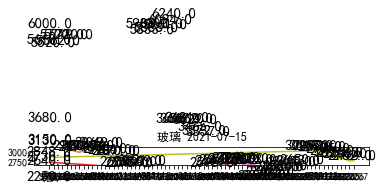

In [124]:
#plt画图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
e = 0
fig=plt.figure()
for key,value in sort_ab.items():
    date = abitrage_dic[key]['date']
    ft_name = key
    names = list(abitrage_dic[key]['合约价格'].keys())
    values = list(abitrage_dic[key]['合约价格'].values())
    n = value
    ax = plt.subplot(len(sort_ab)+1,1,e+1)
    ax.set_ylim((min(values)-100,max(values)+100))
#     ax.bar(names, values,color='cyan')
#     ax.scatter(names, values,color='red')
    ax.plot(names, values)
    for a,b in abitrage_dic[key]['合约价格'].items():
      ax.text(a, b+0.5, '%.1f' % b, ha='center',weight = "light",va= 'bottom',fontsize=15)
    ax.set_title(ft_name+' '+date)
#     ax.tick_params(labelsize="large")
    # plt.xlabel("期现",fontproperties = 'Simhei',fontsize = 18)#设置x坐标标注，字体为18号
    # plt.ylabel("价格",fontproperties = 'Simhei',fontsize = 18)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure()

rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)

ax1.plot(x1, y1, '-og', ms=3)
ax2.plot(x2, y2, '-ob', ms=3)

c:\users\17218\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


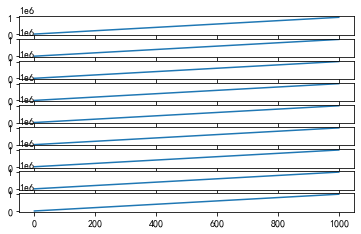

In [88]:
# axs画图
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(len(sort_ab)+1, 1)

for i in range(len(sort_ab)):
    ax = fig.add_subplot(gs[i])
    for key,value in sort_ab.items():
        date = abitrage_dic[key]['date']
        ft_name = key
        names = list(abitrage_dic[key]['合约价格'].keys())
        values = list(abitrage_dic[key]['合约价格'].values())
        n = value
        fig=plt.figure(figsize=(n+1,5))
        plt.ylim((min(values)-100,max(values)+100))
        plt.bar(names, values,color='cyan')
        plt.scatter(names, values,color='red')
        plt.plot(names, values)
# ax.set_ylabel('YLabel0')
# ax.set_xlabel('XLabel0')

# for i in range(2):
#     ax = fig.add_subplot(gs[1, i])
#     ax.plot(np.arange(1., 0., -0.1) * 2000., np.arange(1., 0., -0.1))
#     ax.set_ylabel('YLabel1 %d' % i)
#     ax.set_xlabel('XLabel1 %d' % i)
#     if i == 0:
#         for tick in ax.get_xticklabels():
#             tick.set_rotation(55)
# fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.show()

In [293]:

data = ak.futures_zh_minute_sina(symbol="m2109", period="1")
data['date'] = data['date'].apply(lambda x:datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
data.close = data.close.astype('float64')
data = data[data.date==datetime.strptime(time+' 15:00:00', "%Y-%m-%d %H:%M:%S")]
data

IndexError: list index out of range

In [43]:
# market="CF"; market="CF": 商品期货, market="FF": 金融期货
#adjust=False; adjust=True: 返回合约、交易所和最小变动单位的实时数据, 返回数据会变慢
import akshare as ak
data = ak.futures_zh_spot(subscribe_list="M2109",market="CF",adjust=False)  
data
# help(ak.futures_zh_spot)
# dir(ak.futures_to_spot_czce)
# futures_spot_price',
#  'futures_spot_price_daily',
#  'futures_spot_price_previous',
#  'futures_spot_stock',
#  'futures_to_spot_czce',
#  'futures_to_spot_dce',
#  'futures_to_spot_shfe',
#  'futures_xgx_index',
#  'futures_zh_minute_sina',
#  'futures_zh_spot',

,symbol,time,open,high,low,current_price,bid_price,ask_price,buy_vol,sell_vol,hold,volume,avg_price,last_close,last_settle_price
0,豆粕2109,150002,3636.00,3678.00,3627.00,3662.00,3661.00,3662.00,131,625,1094807,805020,3656.00,3625.00,3617.00
